In [1]:
# Load project package
@load_pkg BayesFitUtils

import Revise
# Import project package
import BayesFitUtils
# Import library to list files
import Glob
# Import package to save chains into memory
import BSON

# Import package to handle DataFrames
import DataFrames as DF
import CSV
import XLSX

# Import basic statistical functions
import StatsBase
import Random

# Import basic math
import LinearAlgebra

# Load CairoMakie for plotting
using CairoMakie
import ColorSchemes
import Makie
# Activate backend
CairoMakie.activate!()

# Set PBoC Plotting style
BayesFitUtils.viz.pboc_makie!()

# Bayesian inference of mean fitness

In this notebook, we will perform Bayesian parameter inference on the population
mean fitness $\bar{s}_t$, given the log frequency changes we measure via
sequencing. Our inference problem **for a single time point** takes the form
$$
P(\bar{s}_t \mid D) \propto P(D \mid \bar{s}_t) P(\bar{s}_t),
$$
where $D$ represents our data. For this particular case, our data are defined as
the log ratios of frequencies for a particular neutral lineage between two
contiguous time points
$$
D = \{\mathcal{L}_t^{(1)}, \mathcal{L}_t^{(2)}, \ldots, \mathcal{L}_t^{(N)}\},
$$
where $\mathcal{L}_t^{(n)}$ is defined as
$$
\mathcal{L}_t^{(n)} \equiv \log 
\left(\frac{f_{t+1}^{(n)}}{f_{t}^{(n)}} \right),
$$
with $f_t^{(n)}$ as the frequency of neutral $n$ at time $t$.

## The likelihood

Having set up the problem, we will define the likelihood. First, we assume all
measurements are independent of each other, resulting in
$$
P(D \mid \bar{s}_t) = \prod_{n=1}^N 
P\left(\mathcal{L}_t^{(n)} \mid \bar{s}_t\right),
$$
where $N$ is the number of neutral lineages Furthermore, we will assume a
Gaussian likelihood such that
$$
\mathcal{L}_t^{(n)} \mid \bar{s}_t, \sigma_{s_t} \sim 
\mathcal{N}\left(- \bar{s}_t, \sigma_{s_t} \right),
$$
where we added the nuisance parameter $\sigma_{s_t}$ to the likelihood.

## The prior

For the prior, given the new nuisance parameter, we assume that both parameters
are independent, i.e.,
$$
P(\bar{s}_t, \sigma_{s_t}) = P(\bar{s}_t)P(\sigma_{s_t}).
$$
Furthermore, we assume uninformative priors for both parameters, $\bar{s}_t$
being a location parameter with uniform prior
$$
\bar{s}_t \sim 
\text{Unif}\left(\frac{1}{\bar{s}_t^{\max} -\bar{s}_t^{\min}} \right)\;
\text{for }\; \bar{s}_t \in [\bar{s}_t^{\min}, \bar{s}_t^{\max}],
$$
and $\sigma_{s_t}$ being a scale parameter with Jeffrey's prior
$$
\sigma_{s_t} \propto \frac{1}{\sigma_{s_t}}\; \text{for }\; \sigma_{s_t} > 0.
$$

## Marginalizing nuisance parameter

To remove the nuisance parameter, we marginalize it out. This means, we compute
$$
P(\bar{s}_t \mid D) = 
\int_0^\infty d\sigma_{s_t} P(\bar{s}_t, \sigma_{s_t} \mid D).
$$
After performing a bunch of tricks and approximations, we arrive at the simple
functional form
$$
P(\bar{s}_t \mid D) \propto 
\left[ 
    \sum_{n=1}^N \left( \mathcal{L}_t^{n} - (- \bar{s}_t) \right)^2 
\right]^{\frac{N}{2}}.
$$
Taking the log of this probability density gives
$$
L(\bar{s}_t \mid D) = \log P(\bar{s}_t \mid D) \propto
\frac{N}{2} \log \left[ 
    \sum_{n=1}^N \left( \mathcal{L}_t^{n} - (- \bar{s}_t) \right)^2 
\right].
$$

Let's write down a function that evaluates this log likelihood.

In [27]:
@doc raw"""
    `logP_meanfitness(s̄ₜ, data)`

# Arguments
- `s̄ₜ::AbstractFloat`: Value of the mean fitness on which to evaluate the
  posterior density.
- `data::Vector{AbstractFloat}`: Array with log frequency changes for each of the
  neutral lineages.
"""
function logP_meanfitness(
    s̄ₜ::AbstractFloat, data::AbstractVector{<:AbstractFloat}
)
    # Extract number of data points
    N = length(data)
    # Evaluate and return log probability
    return - (N / 2) * log(sum((data .- s̄ₜ).^2))
end # function

logP_meanfitness

### Loading the data

Let's now load some of the #BigBatch data

In [3]:
# Load data
df = CSV.read("$(git_root())/data/big_batch/tidy_counts.csv", DF.DataFrame)

first(df, 5)

Row,BCID_x,bc_merged,barcode,barcode_lowcomplexity,barcode_highcomplexity,BCID_y,barcode_fasta,source_publication,cloneID,cloneID_new,evolution_condition,ancestor,class,ploidy,ploidy_new,gene,type,additional_muts,1D_Fitness_Li2019,1D_Error_Li2019,2D_Fitness_Li2019,2D_Error_Li2019,3D_Fitness_Li2019,3D_Error_Li2019,5D_Fitness_Li2019,5D_Error_Li2019,FerPerHour_Li2019,ResPerHour_Li2019,StaPerHour_Li2019,name,count,rep,timepoint,time,batch,hub,perturbation,neutral
,Int64,String,String,String31,String,Int64,String,String15,String31,String?,String7,String15,String31,String15,String15,String31,String?,String?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,String,Int64,String3,String3,Int64,String7,String7,String15,Bool
1,0,GAGTGAAACATGAATGGTATTCATCATGATCAATCTACAAAAATATTTAATG,TGATCAATCTACAAAAATATTTAATG_GAGTGAAACATGAATGGTATTCATCA,TGATCAATCTACAAAAATATTTAATG,GAGTGAAACATGAATGGTATTCATCA,0,GAGTGAAACATGAATGGTATTCATCATGATCAATCTACAAAAATATTTAATG,This_study,missing,EVO2D_IRA1_MIS_rearray_Plate1-A1,Evo2D,IRA1_MIS,missing,missing,diploid,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,Batch1_1Day-T0_combined,53,R1,T0,0,Batch1,1Day,28,false
2,1,ACTCTAACGTGTAACTAATTTTGAGTCCGCCAATCCCGAACCCCGTTTCGCC,CCGCCAATCCCGAACCCCGTTTCGCC_ACTCTAACGTGTAACTAATTTTGAGT,CCGCCAATCCCGAACCCCGTTTCGCC,ACTCTAACGTGTAACTAATTTTGAGT,1,ACTCTAACGTGTAACTAATTTTGAGTCCGCCAATCCCGAACCCCGTTTCGCC,Aggeli2020,gpb2_evo1_plate9_H8,gpb2_evo1_plate9_H8,Evo2D,GPB2,adaptive_haploids,Haploid,Haploid,missing,Other,DOP1-NON_SYNONYMOUS_CODING; SMD2-NON_SYNONYMOUS_CODING; YDL180W-DOWNSTREAM; LAS21-UPSTREAM,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,Batch1_1Day-T0_combined,1213,R1,T0,0,Batch1,1Day,28,false
3,2,ATGGGAACACGGAATGATCTTTTATTGACAGAAAAGCCAAATGGATTTACCG,GACAGAAAAGCCAAATGGATTTACCG_ATGGGAACACGGAATGATCTTTTATT,GACAGAAAAGCCAAATGGATTTACCG,ATGGGAACACGGAATGATCTTTTATT,2,ATGGGAACACGGAATGATCTTTTATTGACAGAAAAGCCAAATGGATTTACCG,This_study,missing,EVO3D_TCG_rearray_Plate1-A4,Evo3D,CYR1,missing,missing,diploid,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,Batch1_1Day-T0_combined,17,R1,T0,0,Batch1,1Day,28,false
4,3,TACTAAATAAGTAAGGGAATTCTGTTCCAACAAAACACAAATCTGTTGTGTA,CCAACAAAACACAAATCTGTTGTGTA_TACTAAATAAGTAAGGGAATTCTGTT,CCAACAAAACACAAATCTGTTGTGTA,TACTAAATAAGTAAGGGAATTCTGTT,3,TACTAAATAAGTAAGGGAATTCTGTTCCAACAAAACACAAATCTGTTGTGTA,This_study,missing,EVO2D_IRA1_NON_rearray_Plate1-A1,Evo2D,IRA1_NON,missing,missing,diploid,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,Batch1_1Day-T0_combined,19,R1,T0,0,Batch1,1Day,28,false
5,4,ATGACAAACTTTAAATAATTTAATTGTATCGAAACCCAAAGAGATTTAATCG,TATCGAAACCCAAAGAGATTTAATCG_ATGACAAACTTTAAATAATTTAATTG,TATCGAAACCCAAAGAGATTTAATCG,ATGACAAACTTTAAATAATTTAATTG,4,ATGACAAACTTTAAATAATTTAATTGTATCGAAACCCAAAGAGATTTAATCG,This_study,missing,EVO3D_IRA1_MIS_rearray_Plate1-C4,Evo3D,IRA1_MIS,missing,missing,haploid,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,Batch1_1Day-T0_combined,23,R1,T0,0,Batch1,1Day,28,false


Next, let's select a particular dataset on which to test our inference.

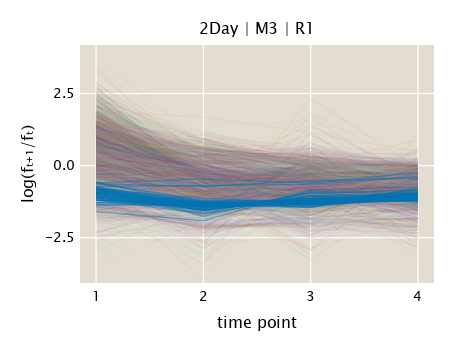

In [4]:
Random.seed!(42)

# Define information for data to extract
batch = "Batch4"
hub = "2Day"
perturbation = "M3"
rep = "R1"

# Extract data. Note: The time T0 is common to all perturbations, thus, it must
# be extracted separately as a second condition.
data = df[
        (df.hub .== hub) .& 
        (df.batch .== batch) .&
        (df.perturbation .== perturbation) .&
        (df.rep .== rep)
    ,
:]

# Extract total counts per barcode
data_total = DF.combine(DF.groupby(data, :time), :count => sum)
# Extract total counts per barcode
data_total = DF.combine(DF.groupby(data, :time), :count => sum)
# Add total count column to dataframe
DF.leftjoin!(data, data_total; on=:time)
# Add frequency column
DF.insertcols!(data, :freq => data.count ./ data.count_sum)

# Initialize dataframe to save the log freq changes
data_log = DF.DataFrame()

# Group data by barcode
data_group = DF.groupby(data, :barcode)

# Loop through each group
for d in data_group
    # Compute log change
    DF.append!(
        data_log, 
        DF.DataFrame(
            :barcode .=> first(d.barcode),
            :time => d.time[2:end],
            :logf => diff(log.(d.freq)),
            :neutral .=> first(d.neutral)
        )
    )
end # for

# Extract data
logf = hcat(
    [
        DF.sort(d, :time).logf
        for d in DF.groupby(data_log[data_log.neutral, :], :barcode)
    ]...
)

# Initialize figure
fig = Figure(resolution=(450, 350))

# Add axis
ax = Axis(
    fig[1, 1],
    xlabel="time point",
    ylabel="log(fₜ₊₁/fₜ)",
    title="$(hub) | $(perturbation) | $(rep)"
)

# Define color palette
colors = ColorSchemes.glasbey_hv_n256

# group data by barcode
data_group = DF.groupby(data_log[.!data_log.neutral, :], :barcode)
# Loop through trajectories
for bc in data_group
    # Plot trajectory
    lines!(
        bc.logf,
        color=(colors[StatsBase.sample(1:length(colors))], 0.05)
    )
end # for

# group neutral barcodes by barcode
data_group = DF.groupby(data_log[data_log.neutral, :], :barcode)
# Loop through trajectories
for bc in data_group
    # Plot trajectory
    lines!(
        bc.logf,
        color=(ColorSchemes.seaborn_colorblind[1], 0.5)
    )
end # for

fig

Finally, let's perform the inference for each time point.

In [48]:
# Define range of s̄ₜ values to evaluate
s_range = collect(LinRange(-1.5, -0.8, 500))

# Initialize array where to save output
logP = Matrix{Float64}(undef, size(logf, 1), length(s_range))

# Loop through each time point
for (t, data) in enumerate(eachrow(logf))
    # Evaluate log probability
    logP[t, :] = [logP_meanfitness(s, Vector(data)) for s in s_range]
end # for

Let's look at the resulting posterior distributions.

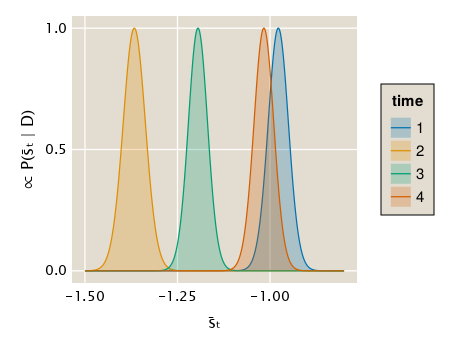

In [50]:
# Initialize figure
fig = Figure(resolution=(450, 350))

# Add axis
ax = Axis(
    fig[1, 1],
    xlabel="s̄ₜ",
    ylabel="∝ P(s̄ₜ | D)"
)

# Define colors
# colors = get(ColorSchemes.Blues_9, LinRange(0.5, 1, size(logP, 1)))
colors = ColorSchemes.seaborn_colorblind

# Loop through time points
for (t, data) in enumerate(eachrow(logP))
    # Plot PDF
    lines!(
        ax, 
        s_range, exp.(data) ./ maximum(exp.(data)), 
        label="$t", 
        color=colors[t]
    )
    # fill distribution
    band!(
        ax,
        s_range,
        zeros(length(s_range)),
        exp.(data) ./ maximum(exp.(data)), 
        color=(colors[t], 0.25),
        label="$t"
    )
end # for

# Add legend
leg = Legend(fig[1, 2], ax, "time", merge=true, unique=true)

fig